In [1]:
import pymongo, pandas as pd, numpy as np, re, sklearn, nltk, operator, seaborn as sb

# Fifth Hypothesis:

In the following notebook it will be analyzed the following hypotesis:
 - **Does there exist a relationship between the text of the review and the number of *votes up* that it receives? Can we predict this value with a Machine Learning model?**

## Correlation between the text of the review and the votes up

We want to start with an easy model that just considers the text of the review and the votes up, in order to understand if there is a correlation between those two features. <br>
If the overall accuracy of that simple model is good enough we'll stop considering it as the optimal one, otherwise we'll add new reasonable features to the model in order to increase the obtained performances.

### Import json reviews dataset & select relevant features to perform the analysis

In [2]:
# Connect to the mongo local and load as a dataframe the small_reviews collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews_filtered.find({}, {'_id': False})))
mongo.close() #Close the connection

In [3]:
df = small_reviews_df
df[['review', 'votes_up']]

,review,votes_up
0,good\n,0
1,"I beat this game 5 times on ps3, when i saw th...",0
2,one of the best 3rd person shooting game,0
3,I enjoy the game. Played it to 100% on PS3 an...,0
4,me cague a tiro con brazucas y me empastille a...,0
...,...,...
307951,Excuse me kind programmer this game isnt worki...,2
307952,"Really fun, great game design. I like the char...",1
307953,"I just bought this game, I like it, it has a l...",1
307954,Age of Rivals is a really interesting card gam...,4


### Divide reviews in two classes: useful & not useful

Since this hypothesis can be used by Steam in order to display, for users that are interested on buying a new game, only the potential useful reviews (the ones having more than N votes up) the idea is to consider only useful and not useful reviews and build a model that is capable of recognizing those two classes. <br>
Since we do not want our model to be biased towards one of the two classes, we'll consider the same number of samples for the two different classes (useful/not useful review).<br>
For us a good review is when its associated *votes_up* has a value greater than the M percentile of the overall *votes_up* distribution.

In [4]:
votes_up_for_useful_review = np.percentile(df['votes_up'], 99)
votes_up_for_useful_review

32.0

In [5]:
useful_review_df = df[df['votes_up'] >= votes_up_for_useful_review]
not_useful_review_df = df[df['votes_up'] < votes_up_for_useful_review].sample(n=len(useful_review_df), random_state=0)
restricted_df = pd.concat([useful_review_df, not_useful_review_df])
restricted_df.sort_index(inplace=True)
restricted_df[['review', 'votes_up']]

,review,votes_up
22,Great game made by a shitty company which forc...,185
33,"Excellent story, script, and gunplay. Highly r...",0
69,Best 3rd person shooters. Wish more people wou...,0
90,"""I felt like the avenging angel. I looked like...",2
161,im highly annoyed that my social club account ...,32
...,...,...
307728,The game is really fun and enjoyable for the f...,2
307749,EDIT: Since this review I have beaten the game...,304
307783,Loved the first Nidhogg.\nThis however. It loo...,91
307797,This game ruined Nidhogg for me. The new chara...,143


In [6]:
# Replace the output label with a 1 (so a good review) if the review's votes up are greater than threshold, 0 otherwise
y = np.array(restricted_df['votes_up'].apply(lambda x: 0 if x < votes_up_for_useful_review else 1))

### Obtain the Bag-Of-Words and predict, using the review text, the votes_up categorical values

#### Obtaining BoW

In [7]:
# Define the vectorizer object that applies stemming and removes english stop words to input documents
CountVectorizer = sklearn.feature_extraction.text.CountVectorizer
stemmer = nltk.stem.SnowballStemmer('english')
analyzer = CountVectorizer(stop_words='english').build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# This function instead is used in order to remove not characters (and \n) in written reviews and make the text lowercase
def clean(input):
    return ''.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, list(re.sub('\n', ' ', input.lower())))))

In [8]:
# Remove to all the documents the not characters and convert them to lowercase
docs = np.array(restricted_df['review'].apply(lambda x: clean(x)))
# Build the vectorizer
stem_vectorizer = CountVectorizer(analyzer=stemmed_words)
# Fit the bag-of-words model
bow = stem_vectorizer.fit_transform(docs)

In [9]:
# Obtain input
X = bow.toarray()

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

#### Make prediction using Logistic Regression (BoW)

We'll start using an easier model and see the effects of using BoW on the overall performances. <br>
In order to obtain a proper value for the C hyperparameter (inverse of regularization term) of the Logistic Regression model a *grid search* approach has been used.

In [10]:
# Create an instance of LogisticRegression classifier
lr = sklearn.linear_model.LogisticRegression(C=0.001, solver='liblinear', multi_class='ovr')
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(X_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Train Logistic Regression accuracy: 70.27
Test Logistic Regression accuracy: 68.22


Those results show (no matter the model) that there is a correlation between the text of the review and the *votes_up* label, otherwise the accuracy of our model would have been of the 50% (randomly picking one class). <br>

## Add new features to the simple model (that just uses reviews' text), to improve predictions 

Can we increase the accuracy of our model by adding new suited features to the model's input?

### Gather all the data about reviews and games and join them on 'appid'

The review data are already stored, so we need to load the data about the games.

In [11]:
# Connect to the mongo local and load as a dataframe the games collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
games_df = pd.DataFrame(list(mongo_db.games.find({}, {'_id': False})))
mongo.close() #Close the connections

games_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
1,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99
2,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action,FPS;Classic;Action,0,27755,1100,1300,83,5000000-10000000,7.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,2,0,0,0,0-20000,5.19
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Adventure;Indie,Action;Indie;Adventure,0,8,1,0,0,0-20000,1.69
27072,1065160,Deatherem,2019-04-23,1,Anima,Team Syukino,windows,0,Single-player;Steam Achievements,Indie,Indie;Horror;First-Person,1,2,2,0,0,0-20000,2.09
27073,1069460,Rune Lord,2019-04-24,1,Adept Studios GD,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Adventure;Casual;Indie,Indie;Casual;Adventure,0,4,0,0,0,0-20000,5.19


#### Better handling of game columns

##### 1. Genres

Since a game can have at least one genre we'll store for each game a dict that has value equal to 1 if the genre applies to the game (0 otherwise).

In [12]:
games_df['genres'] = games_df.genres.str.split(';')
# get all unique genres
all_genres = games_df.genres.apply(pd.Series).stack().reset_index(drop=True).unique()
# a dict for each game, each dict has all of the genres, val=1 if genre applies to game
gen_dicts = games_df.genres.apply(lambda gens : { **{g:0 for g in all_genres}, **{ g:1 for g in gens } } )
# delete now useless column
del games_df['genres']
# merge with original
games_df = pd.concat([games_df.reset_index(drop=True), gen_dicts.apply(pd.Series).reset_index(drop=True)] , axis=1)

In [13]:
games_df

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,steamspy_tags,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
1,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,FPS;Action;Sci-fi,...,0,0,0,0,0,0,0,0,0,0
2,60,Ricochet,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action;FPS;Multiplayer,...,0,0,0,0,0,0,0,0,0,0
4,70,Half-Life,1998-11-08,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,FPS;Classic;Action,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,1066700,New Yankee 7: Deer Hunters,2019-04-17,1,Yustas Game Studio,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Indie;Casual;Adventure,...,0,0,0,0,0,0,0,0,0,0
27071,1065570,Cyber Gun,2019-04-23,1,Semyon Maximov,BekkerDev Studio,windows,0,Single-player,Action;Indie;Adventure,...,0,0,0,0,0,0,0,0,0,0
27072,1065160,Deatherem,2019-04-23,1,Anima,Team Syukino,windows,0,Single-player;Steam Achievements,Indie;Horror;First-Person,...,0,0,0,0,0,0,0,0,0,0
27073,1069460,Rune Lord,2019-04-24,1,Adept Studios GD,Alawar Entertainment,windows;mac,0,Single-player;Steam Cloud,Indie;Casual;Adventure,...,0,0,0,0,0,0,0,0,0,0


##### 2. Owners

Since we know for each game a range of the minimum and maximum number of owners, for each game we will consider the number of owners as a mean of those two values.

In [14]:
games_owners_range = list(games_df.owners.str.split('-'))
# Obtain the minimum and maximum values of owners for each videogame and cast those single values to Int
list_min_games_owners = list(map(int, map(operator.itemgetter(0), games_owners_range)))
list_max_games_owners = list(map(int, map(operator.itemgetter(-1), games_owners_range))) 
# For each game perform the mean value of owners
games_df['owners'] = list(map(int, np.divide(list(map(operator.add, list_min_games_owners, list_max_games_owners)), 2)))
games_df['owners']

0        7500000
1        7500000
2        7500000
3        7500000
4        7500000
          ...   
27070      10000
27071      10000
27072      10000
27073      10000
27074      10000
Name: owners, Length: 27075, dtype: int64

#### Join

In [15]:
# Join the subset of reviews and the games dataset
restricted_and_games_df = restricted_df.merge(games_df, on='appid', how="left")
restricted_and_games_df.sort_index(inplace=True)
restricted_and_games_df

,base_review_id,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,...,Web Publishing,Education,Software Training,Sexual Content,Audio Production,Game Development,Photo Editing,Accounting,Documentary,Tutorial
0,226,76561198028004506,204100,False,185,21,0.794982,20598,20598,157,...,0,0,0,0,0,0,0,0,0,0
1,302,76561198160390945,204100,True,0,0,0.000000,667,667,55,...,0,0,0,0,0,0,0,0,0,0
2,668,76561198019571070,204100,True,0,0,0.000000,3531,3338,31,...,0,0,0,0,0,0,0,0,0,0
3,868,76561197998065347,204100,True,2,1,0.531981,1801,1801,604,...,0,0,0,0,0,0,0,0,0,0
4,1655,76561198066242649,204100,False,32,1,0.503657,3395,3318,282,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6219,68719600518,76561198080037927,535230,True,2,0,0.523810,668,371,85,...,0,0,0,0,0,0,0,0,0,0
6220,68719600719,76561198062454026,535230,False,304,7,0.813597,992,512,266,...,0,0,0,0,0,0,0,0,0,0
6221,68719601152,76561198395351334,535520,False,91,2,0.632847,74,30,85,...,0,0,0,0,0,0,0,0,0,0
6222,68719601196,76561198256911090,535520,False,143,2,0.542396,414,274,106,...,0,0,0,0,0,0,0,0,0,0


### Add videogame owners (normalized), to the simple model (BoW)

If the game is owned by lot of players maybe more user (e.g., that are interested on buying a community liked videogame) are reading the reviews and so more votes_up the review gets.<br>
Applying a normalization to the videogame owners number is necessary since the range of values that this feature can have is larger with respect to the BoW (they can have more weight in the model and so the prediction results become unexpected). <br> A *Mean-Var Normalization* technique has been chosen.

In [16]:
# Obtain input
x1 = X

# Normalize, applying meanvar_scaling, x2, since number of owners is lot greater with respect to BoW
x2 = np.array(restricted_and_games_df['owners'])[:, np.newaxis]
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x2)
x2 = scaler.transform(x2)

# Join the two features
X = np.column_stack([x1, x2])

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

#### Make prediction using Logistic Regression (BoW + owners)

In [17]:
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(X_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Train Logistic Regression accuracy: 71.09
Test Logistic Regression accuracy: 68.06


This result shows that adding the owners really makes no visible improvements (with respect to the model having only the BoW as feature vector).

### Add videogame genre/s, to the simple model (BoW)

From **hp3** we have obtained that some genres are more appreciated with respect to others, so maybe also the associated votes_up for a review is different if the review is referred to a game of a/some genre/s.

In [18]:
# Obtain input
x2 = np.array(restricted_and_games_df.iloc[:, 30:])
# Join the two features
X = np.column_stack([x1, x2])

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

#### Make prediction using Logistic Regression (BoW + genre/s)

In [19]:
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(X_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Train Logistic Regression accuracy: 70.06
Test Logistic Regression accuracy: 69.02


It can be noticed that a slightly improvement is added if considering also the game genre/s. <br>
This suggest to add this feature to our simple model.

### Add how are liked the previous reviews written by a specific user, to the simple model (BoW)

A possible consideration can be: if a person gets lots of likes in previous reviews maybe lots likes also the feature review gets.
<br>
The metric we are performing interested studying is:
 - **user_reviews_appreciation = sum_previous_reviews_votes_up / num_previous_reviews**

In [20]:
restricted_and_games_df['user_reviews_appreciation'] = (restricted_and_games_df
                                                        .sort_values(by='unix_timestamp_created')
                                                        .groupby('steamid')['votes_up']
                                                        .apply(lambda x: x.shift().expanding().mean())
                                                        )

# Replacing NaN values (user have written 0 previous reviews) with mean reviews likes value
restricted_and_games_df['user_reviews_appreciation'] = restricted_and_games_df['user_reviews_appreciation']\
                                                       .fillna(restricted_and_games_df['user_reviews_appreciation']\
                                                       .mean())

# Show how it works
restricted_and_games_df[restricted_and_games_df.duplicated('steamid', keep=False)]\
    .sort_values(by=['steamid', 'unix_timestamp_created'])\
    [['steamid', 'unix_timestamp_created', 'votes_up', 'user_reviews_appreciation']]

,steamid,unix_timestamp_created,votes_up,user_reviews_appreciation
2799,76561197961635953,1428147682,54,139.103552
5947,76561197961635953,1494068627,76,54.000000
4399,76561197961635953,1519534770,714,65.000000
2527,76561197961635953,1528773372,44,281.333333
1248,76561197964471157,1438149222,65,139.103552
...,...,...,...,...
3101,76561198315585536,1572412165,39,43.166667
4826,76561198388606792,1614620251,40,139.103552
4291,76561198388606792,1618080032,62,40.000000
4641,76561198405177339,1592010163,458,139.103552


In [21]:
# Normalize user reviews appreciation
x2 = np.array(restricted_and_games_df['user_reviews_appreciation'])[:, np.newaxis]
scaler.fit(x2)
x2 = scaler.transform(x2)
# Join the two features
X = np.column_stack([x1, x2])

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

#### Logistic Regression (BoW + user_reviews_appreciation)

In [22]:
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(X_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Train Logistic Regression accuracy: 70.29
Test Logistic Regression accuracy: 68.06


Even in this case adding the previous reviews appreciation really makes no visible improvements (with respect to the model having only the BoW as feature vector).

### Best model

We noticed that adding some features increases more with respect to other the overall accuracy is better to add only the more relevant ones (the ones that are changing most the accuracy). <br>
In this particular case, the only one that metters is the videogame genre/s.

In [23]:
# GAME GENRE/S
x2 = np.array(restricted_and_games_df.iloc[:, 30:-1])

# Join the more relevant features (x1 = Bow, x2 = game genre/s)
X = np.column_stack([x1, x2])

# Create training and test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, shuffle=True, random_state=0)

##### Logistic Regression (BoW + genre/s)

In [24]:
# Fit the model
lr.fit(X_train, y_train)
# Create the predictions
lr_y_predict = lr.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, lr.predict(X_train)) * 100))
print("Test Logistic Regression accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, lr_y_predict) * 100))

Train Logistic Regression accuracy: 70.06
Test Logistic Regression accuracy: 69.02


The overall accuracy of the obtained model can be considered neither good nor terrible (considering that classification with NLP is not so easy). <br>
But what happens if we use instead different models such as SVM (using the more relevant features)?

##### Support Vector Machine (BoW + genre/s)

Now we want to consider a more complex model. <br>
In order to obtain a proper value for the C hyperparameter (regularization term) of the SVM model a *grid search* approach has been used.

In [25]:
# Create an instance of SVM classifier
svm = sklearn.svm.SVC(C=0.1)
# Fit the model
svm.fit(X_train, y_train)
# Create the predictions
svm_y_predict = svm.predict(X_test)
# Use metrics.accuracy_score to measure the score
print("Train SVM accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_train, svm.predict(X_train)) * 100))
print("Test SVM accuracy: %.2f" % (sklearn.metrics.accuracy_score(y_test, svm_y_predict) * 100))

Train SVM accuracy: 69.74
Test SVM accuracy: 68.54


SVM model does not improve the overall accuracy with respect to the Logistic Regression, moreover it takes more time to train, a not negligible aspect.

### Model evaluation - using the "best model"

Is our "best model" more biased towards recognizing one of the two classes?

In [26]:
lr_acc = sklearn.metrics.accuracy_score(y_test, lr_y_predict)
svm_acc = sklearn.metrics.accuracy_score(y_test, svm_y_predict)
best_y_predict = svm_y_predict if svm_acc > lr_acc else lr_y_predict
best_model = svm if svm_acc > lr_acc else lr

#### Confusion Matrix

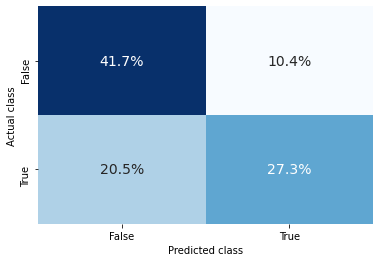

In [27]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test, best_y_predict)
sb.heatmap(cf_matrix/np.sum(cf_matrix),
           annot=True,
           fmt='.1%',
           cmap='Blues',
           cbar=False,
           xticklabels=['False', 'True'], yticklabels=['False', 'True'],
           annot_kws={
                'fontsize': 14
            }).set(xlabel='Predicted class', ylabel='Actual class');

#### Precision & Recall

https://www.askpython.com/python/examples/precision-and-recall-in-python

Best model: Logistic Regression 

Precision:  0.72 
Recall:  0.57 
F1: 0.64
Area under Precision-Recall curve:  0.75


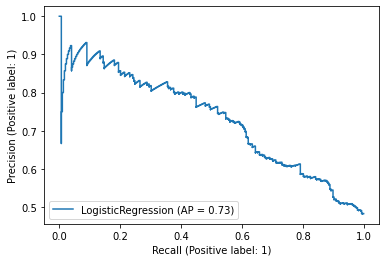

In [28]:
# Obtain precision, recall & f1 metrics
precision = sklearn.metrics.precision_score(y_test, best_y_predict)
recall = sklearn.metrics.recall_score(y_test, best_y_predict)
f1 = sklearn.metrics.f1_score(y_test, best_y_predict)

print('Best model:', 'SVM' if svm_acc > lr_acc else 'Logistic Regression',
     '\n\nPrecision: ', round(precision, 2), '\nRecall: ', round(recall, 2), '\nF1:', round(f1,2))

# Obtain Precision-Recall Curve data to compute the AUC
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, best_y_predict)
auc_precision_recall = sklearn.metrics.auc(recall, precision)
print('Area under Precision-Recall curve: ', round(auc_precision_recall, 2))
 
#Plotting Precision-Recall Curve
disp = sklearn.metrics.plot_precision_recall_curve(best_model, X_test, y_test)
disp;